In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import folium
from folium.plugins import HeatMap
from IPython.display import display, HTML

In [10]:
# Loading env variables and settting log level
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
CLEANED_DATA_PATH = os.getenv("CLEANED_DATA_PATH", r"C:\Users\Aneesh\Downloads\data-insights\data-insights\data\processed\cleaned_aggregated_data.csv")
sns.set_theme(style="whitegrid")

In [12]:
# Read file function
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Loaded data from {file_path} with shape {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Failed to load raw data: {e}")
        return pd.DataFrame()

In [14]:
# Reading file from raw path
df = read_csv_file(CLEANED_DATA_PATH)
if df.empty:
    raise SystemExit("File not found")

2025-06-15 17:33:20,750 - INFO - Loaded data from C:\Users\Aneesh\Downloads\data-insights\data-insights\data\processed\cleaned_aggregated_data.csv with shape (3309, 9)


In [18]:
# Total registered disabilities
total_registrations = df['total'].sum()
logging.info(f"Total Registrations: {total_registrations}")

2025-06-15 17:34:51,844 - INFO - Total Registrations: 869244


In [20]:
# District and Disabilities Insights
unique_districts = df['district_name'].nunique()
unique_disabilities = df['disability'].nunique()
logging.info(f"Unique Districts: {unique_districts}")
logging.info(f"Unique Disabilities: {unique_disabilities}")

2025-06-15 17:35:00,198 - INFO - Unique Districts: 31
2025-06-15 17:35:00,200 - INFO - Unique Disabilities: 21


In [22]:
# Total number of disabilities per district(descending)
district_registrations = df.groupby('district_name')['total'].sum().sort_values(ascending=False)
logging.info(f"District-wise Registrations:\n{district_registrations}")

2025-06-15 17:35:07,079 - INFO - District-wise Registrations:
district_name
Belagavi            86288
Tumakuru            48246
Bengaluru Urban     47979
Haveri              36952
Mysuru              35771
Vijayapura          35551
Kalaburagi          34502
Chitradurga         33342
Ballari             31888
Bagalkote           31720
Dharwad             31123
Raichur             29457
Yadgir              28464
Davangere           28252
Hassan              27726
Mandya              27510
Dakshina Kannada    23607
Koppal              22945
Bidar               22572
Chikkaballapura     21786
Uttara Kannada      21686
Kolar               21436
Shivamogga          20992
Gadag               20640
Chamarajanagara     18352
Chikkamagaluru      17071
Udupi               16068
Bengaluru Rural     15850
Ramanagara          15754
Vijayanagar          8698
Kodagu               7016
Name: total, dtype: int64


In [24]:
# Gender wise disabilities
gender_distribution = df[['male', 'female', 'other']].sum()
logging.info(f"Gender Distribution:\n{gender_distribution}")

2025-06-15 17:35:14,405 - INFO - Gender Distribution:
male      555911
female    313182
other        151
dtype: int64


In [26]:
# Age-wise distribution of disabilities
age_distribution = df.groupby('age_group')['total'].sum()
logging.info(f"Age-wise Distribution:\n{age_distribution}")

2025-06-15 17:35:28,177 - INFO - Age-wise Distribution:
age_group
0-6        7721
15-35    250752
35-60    410560
6-15      82683
60-80    110018
80+        7510
Name: total, dtype: int64


In [28]:
# Disability wise distribution
disability_distribution = df.groupby('disability')['total'].sum().sort_values(ascending=False)
logging.info(f"Disability-wise Registrations:\n{disability_distribution}")

2025-06-15 17:35:50,960 - INFO - Disability-wise Registrations:
disability
Locomotor Disability               433714
Intellectual Disability            105454
Hearing Impairment                  99667
Blindness                           80112
Mental Illness                      43914
Low Vision                          34289
Multiple Disabilities               24911
Cerebral Palsy                      13420
Chronic Neurological Conditions     13085
Speech And Language Disability       5796
Muscular Dystrophy                   3230
Dwarfism                             3117
Autism Spectrum Disorder             1995
Leprosy Cured                        1459
Hemophilia                           1355
Thalassemia                          1314
Multiple Sclerosis                    727
Parkinson'S Disease                   680
Acid Attack Victim                    503
Specific Learning Disabilities        337
Sickle Cell Disease                   165
Name: total, dtype: int64


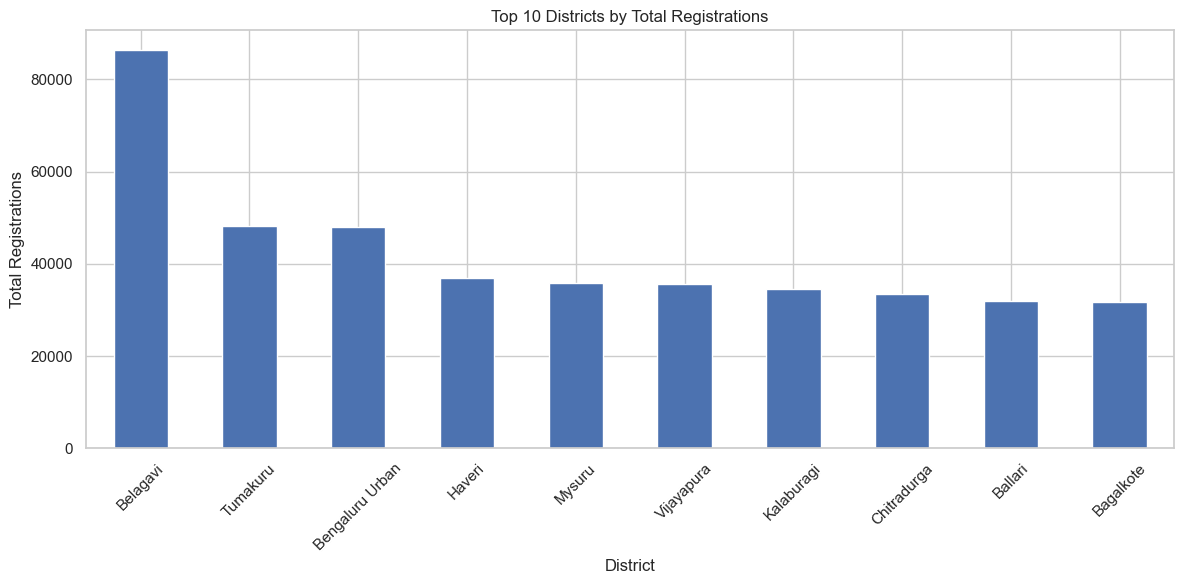

In [30]:
# Top 10 Districts by Total Registrations
plt.figure(figsize=(12, 6))
district_registrations.head(10).plot(kind='bar')
plt.title('Top 10 Districts by Total Registrations')
plt.xlabel('District')
plt.ylabel('Total Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('district_registrations.png')
plt.show()

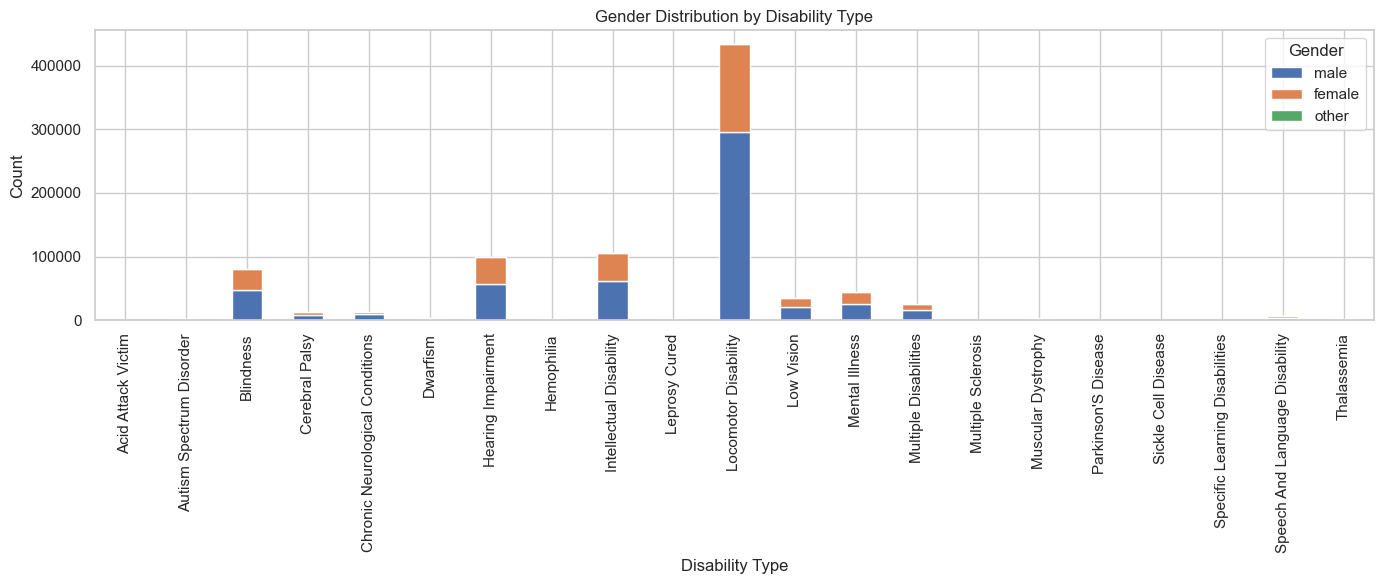

In [32]:
# Gender Distribution by Disability Type
gender_by_disability = df.groupby('disability')[['male', 'female', 'other']].sum()
gender_by_disability.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Gender Distribution by Disability Type')
plt.xlabel('Disability Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('gender_distribution.png')
plt.show()

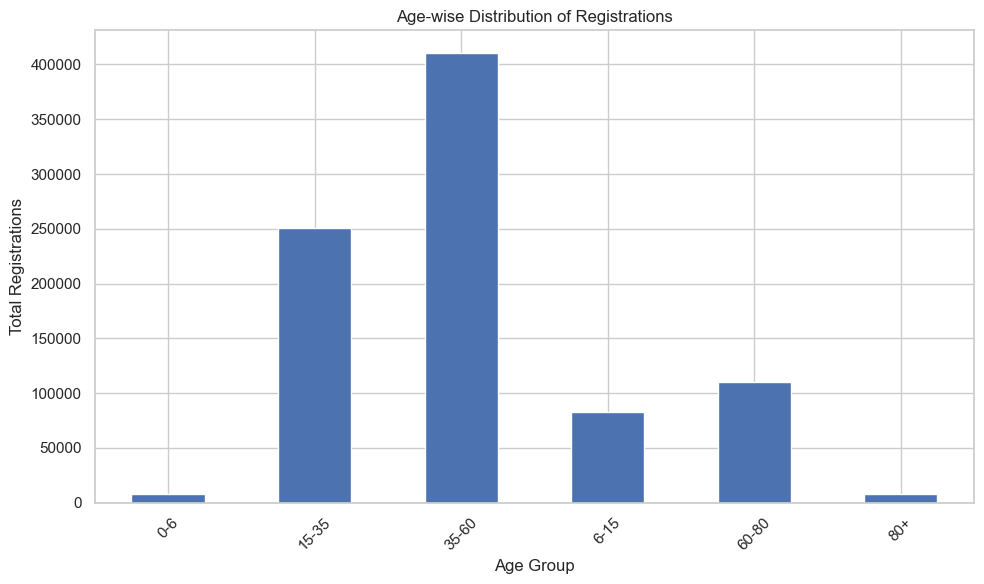

In [34]:
# Age-wise Distribution of Registrations
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Age-wise Distribution of Registrations')
plt.xlabel('Age Group')
plt.ylabel('Total Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()

In [42]:
district_coords = {
    'Bagalkote': [16.1850, 75.6950],
    'Ballari': [15.1394, 76.9214],
    'Belagavi': [15.8497, 74.4977],
    'Bengaluru Rural': [13.2257, 77.5750]
}

In [54]:
district_data = df.groupby('district_name')['total'].sum().reset_index()
district_data['latitude'] = district_data['district_name'].map(lambda x: district_coords.get(x, [0, 0])[0])
district_data['longitude'] = district_data['district_name'].map(lambda x: district_coords.get(x, [0, 0])[1])
m = folium.Map(location=[15.3173, 75.7139], zoom_start=7)
heat_data = [[row['latitude'], row['longitude'], row['total']] for _, row in district_data.iterrows() if row['latitude'] != 0]
HeatMap(heat_data, radius=15).add_to(m)
m.save(r"C:\Users\Aneesh\Downloads\data-insights\data-insights\data\processed\district_heatmap.html")